**Requirements:**<br>
The goal is to input an artist's name and output songs and specific time locations in a song with an indication on how to interpret similarity of the samples that were given.

**Assumption:**<br>
The main assumption in this Project is that the audio files reside in Spotify and the following script uses heavily the audio analytics provided by Spotify Web API.

**High-level Overview**<br>
* The User enters an artist's name as Input.
* The System collects the data of a random creation of the artist.
* The System them collects the data of similar artists' creations and evaluates similar 'song segments' - these are parts of a song containing a roughly consistent sound throughout its duration.
* The System then recommends segments of other songs which are similar to the ones in the Referenced song of the given Artist along with the time-duration of the song segment and the audio property which is used to evaluate the 'closeness' (Ex - Loudness, Pitchness, Timbre, etc.).
* These indicators will help the artist combine different song-segments in specific ways of their choice.

**Approach:**<br>
The following steps mainly outlines the approach taken to solve the problem :-

* Take the Artist's name as Input from User.
* Gather some of the Artist's tracks from Spotify and choose a song randomly.
* Gather some songs of Artists similar to the one User provided (this has been hardcoded explicitly here).
* Invoke Spotify Audio analysis of all the tracks.
* Build a dataset consisting of all the 'parts/segments of songs' for all the songs.
* Use the dataset to build an Unsupervised Model using KMeans Clustering algorithm to Cluster the Song segments.
* Build Nearest Neighbors Unsupervised learners from each Cluster obtained above.
* Get 5 Nearest Neighbor for each Song segment and recommend song segments similar to the Referenced song as evaluated above if the inter-point distance is less than the Median distance.
* The number of recommendations per Cluster has been capped at 10.


**Future Improvements:**<br>
* KMeans algorithm has been used here to build the Clusters. Other more complex algorithms like DBSCAN can be evaluated on the built dataset.
* All the features in 'segments' data from the Audio analysis are used here. More analysis can be performed to vet which features (if any) can be removed.
* This project recommends related sound segments from a few of the other artist's albums. However, it can be extended to a larger dataset based on similar genre.
* Other track features such as popularity of tracks can be used in the final recommendation - the rationale being some song segments can be used to mix with other segments to generate popular mixes.
* From the Audio Analysis, only the 'segments' data has been used here to build the Solution. However, other Audio Analysis Objects can be used to build models as well. There is scope of researching in this regards and evaluate the best Solution.

**Alternative Approach:**<br>
Since the recommendation is made from the Spotify Audio Analytics, we do have some level of information for every sound track which describes the different features in the Audio file. These include - danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo.
These properties can be used to recommend songs (rather than song segments) to the artists to take inspiration from. This is very similar to music recommendation to Users.

In [4]:
! pip install spotipy

  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Import the necessary libraries
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle

import spotipy
import spotipy.util as util
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [0]:
# Connect to Spotify's Web API and obtain Token
username = input('UserName: ')
client_id = input('Client_ID: ')
client_secret = input('Client_Secret: ')
redirect_uri = input('Redirect_URI: ')

try:
    token = util.prompt_for_user_token(username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
except:
    os.remove(f'.cache-{username}')
    token = util.prompt_for_user_token(username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

spotify = spotipy.Spotify(auth=token)

In [8]:
%%time
# Obtain the data for songs of the Artist

def get_tracks(results):
    '''
    This Function takes the artist's data as I/P and returns all the albums and their associated tracks.
    # 'tracks' contain the mapping of the Tracks and URI
    # 'albums' contain the mapping of the Albums and URI
    '''
    albums = dict()
    tracks = dict()

    for album in results['albums']['items']:
        albums[album['name']] = album['uri']

    for album in albums:
        album_tracks = spotify.album_tracks(albums[album])
        for track in album_tracks['items']:
            tracks[track['name']] = track['uri']
            
    print(f'# of Albums: {len(albums)}\n# of Tracks: {len(tracks)}\n')
    return albums, tracks

name = 'Eminem'
results = spotify.search(q='artist:' + name, type='album', limit=50)
# print(results)
albums, tracks = get_tracks(results)


sel_track = np.random.choice(list(tracks), 1)[0]
sel_uri = tracks[sel_track]

print("Selection :-")
print(sel_track, "=====>", sel_uri)

# of Albums: 31
# of Tracks: 251

Selection :-
Lounge - Skit =====> spotify:track:0X0ClM8jVHU7N0ptHRqi7r
CPU times: user 346 ms, sys: 26.1 ms, total: 372 ms
Wall time: 2.25 s


In [9]:
%%time
# Obtain the data for songs of other similar Artists
sim_artists = ['Yelawolf', '50 Cent', 'Dr. Dre', '2Pac', 'JAY-Z']
all_albums = dict()
all_tracks = {sel_track: sel_uri}

for name in sim_artists:
    print(f'Processing Artist - {name}...')
    results = spotify.search(q='artist:' + name, type='album', limit=10)
    albums, tracks = get_tracks(results)
    all_albums.update(albums)
    all_tracks.update(tracks)
    
print(f'Total #Albums: {len(all_albums)}\nTotal #Tracks: {len(all_tracks)}\n')

Processing Artist - Yelawolf...
# of Albums: 9
# of Tracks: 92

Processing Artist - 50 Cent...
# of Albums: 10
# of Tracks: 97

Processing Artist - Dr. Dre...
# of Albums: 7
# of Tracks: 50

Processing Artist - 2Pac...
# of Albums: 10
# of Tracks: 197

Processing Artist - JAY-Z...
# of Albums: 6
# of Tracks: 48

Total #Albums: 42
Total #Tracks: 482

CPU times: user 507 ms, sys: 33 ms, total: 540 ms
Wall time: 3.91 s


In [13]:
%%time
# 'data' contains the features of all the tracks
data = []
for i in tqdm(range(0, len(all_tracks), 10)):
    feats = spotify.audio_features(list(all_tracks.values())[i:i+10])
    for feat in feats:
        data.append(list(feat.values()))
    
data = pd.DataFrame(data, columns=feats[0].keys())

100%|██████████| 49/49 [00:03<00:00, 14.77it/s]

CPU times: user 576 ms, sys: 41.6 ms, total: 617 ms
Wall time: 3.33 s


In [14]:
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.324,0.353,4,-18.873,1,0.090,0.61000,0.000000,0.9030,0.848,113.898,audio_features,0X0ClM8jVHU7N0ptHRqi7r,spotify:track:0X0ClM8jVHU7N0ptHRqi7r,https://api.spotify.com/v1/tracks/0X0ClM8jVHU7...,https://api.spotify.com/v1/audio-analysis/0X0C...,46533,3
1,0.745,0.973,0,-3.375,1,0.160,0.08430,0.005720,0.3310,0.429,117.030,audio_features,5W1Qt1tvO4OESyz7up2dkW,spotify:track:5W1Qt1tvO4OESyz7up2dkW,https://api.spotify.com/v1/tracks/5W1Qt1tvO4OE...,https://api.spotify.com/v1/audio-analysis/5W1Q...,241213,4
2,0.656,0.908,2,-4.400,0,0.202,0.12700,0.000003,0.2270,0.256,89.983,audio_features,5utv22i6vp4lOQt17JAOo8,spotify:track:5utv22i6vp4lOQt17JAOo8,https://api.spotify.com/v1/tracks/5utv22i6vp4l...,https://api.spotify.com/v1/audio-analysis/5utv...,192373,4
3,0.752,0.754,9,-5.061,1,0.133,0.18600,0.000000,0.1100,0.353,82.986,audio_features,2g5cChGDcrjtpRVGA7q4Eh,spotify:track:2g5cChGDcrjtpRVGA7q4Eh,https://api.spotify.com/v1/tracks/2g5cChGDcrjt...,https://api.spotify.com/v1/audio-analysis/2g5c...,212147,4
4,0.593,0.936,4,-2.829,0,0.123,0.00121,0.000012,0.0812,0.363,152.017,audio_features,1hr58cC3N5WwL7CF4yDTxh,spotify:track:1hr58cC3N5WwL7CF4yDTxh,https://api.spotify.com/v1/tracks/1hr58cC3N5Ww...,https://api.spotify.com/v1/audio-analysis/1hr5...,248467,4


In [15]:
%%time
# The following script creates a Data Frame containing the details of Audio Analysis
# 'song_segments' contains the song segments for all the songs
# 'song_seg_mapping' contains a mapping between the segment data and the track URI
song_segments = []
seg_cols = []

song_seg_mapping = dict()

for uri in tqdm(data['uri'].values):
    results = spotify.audio_analysis(uri)
    time.sleep(3)
    for segment in results['segments'][:-1]:
        temp = []
        for item in segment:
            if item == 'pitches' or item == 'timbre':
                temp.extend(segment[item])
            else:
                temp.append(segment[item])
            
#         song_seg_mapping[repr(temp)] = uri
        song_seg_mapping[repr(temp)] = "https://open.spotify.com/track/" + uri.split(':')[-1]
        song_segments.append(temp)
    
for key, val in segment.items():
    if key == 'pitches' or key == 'timbre':
        for i in range(len(val)):
            seg_cols.append(f'{key}_{i}')
    else:
        seg_cols.append(key)
        
song_segments = pd.DataFrame(song_segments, columns=seg_cols)

100%|██████████| 482/482 [32:52<00:00,  3.93s/it]


CPU times: user 30.6 s, sys: 1.67 s, total: 32.3 s
Wall time: 32min 55s


In [17]:
%%time
pickle.dump(song_seg_mapping, open("gdrive/My Drive/Colab Notebooks/Music Similarity/song_seg_mapping.pickle", "wb"))
song_segments.to_csv(path_or_buf='gdrive/My Drive/Colab Notebooks/Music Similarity/Song_Segments.csv', index=False)

CPU times: user 16.2 s, sys: 474 ms, total: 16.7 s
Wall time: 18.4 s


In [0]:
# song_segments.to_csv(index=False)
# results.keys() -- dict_keys(['meta', 'track', 'bars', 'beats', 'tatums', 'sections', 'segments'])
# results['tatums']

In [0]:
song_segments = pd.read_csv(filepath_or_buffer='gdrive/My Drive/Colab Notebooks/Music Similarity/Song_Segments.csv')

In [18]:
%%time

sel_song_segs = []
for segment in tqdm(song_seg_mapping):
    if song_seg_mapping[segment].split('/')[-1] == sel_uri.split(':')[-1]:
        sel_song_segs.append(segment)
#         sel_song_segs[repr(segment)] = 1
#         print(song_seg_mapping[segment], segment)

print(f'\nSong Segments in "{sel_track}" - {len(sel_song_segs)}')

100%|██████████| 501799/501799 [00:00<00:00, 674860.06it/s]


Song Segments in "Lounge - Skit" - 168
CPU times: user 735 ms, sys: 6.45 ms, total: 742 ms
Wall time: 753 ms


In [19]:
song_segments.head()

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,pitches_0,pitches_1,pitches_2,pitches_3,pitches_4,pitches_5,pitches_6,pitches_7,pitches_8,pitches_9,pitches_10,pitches_11,timbre_0,timbre_1,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11
0,0.00000,0.20862,1.000,-60.000,0.06022,-45.737,0.258,0.232,0.124,0.109,0.117,0.149,0.258,0.411,0.258,0.529,1.000,0.681,11.028,62.716,-28.040,-19.262,62.764,6.081,-18.135,45.567,-34.768,42.147,16.143,-22.695
1,0.20862,0.18082,0.904,-51.479,0.05598,-38.801,0.833,1.000,0.528,0.389,0.519,0.410,0.457,0.544,0.602,0.417,0.354,0.839,17.133,65.201,-25.848,-56.757,103.792,-7.934,-9.319,42.216,-14.529,10.093,-21.239,-30.285
2,0.38943,0.24213,0.829,-45.182,0.12875,-34.285,1.000,0.585,0.399,0.282,0.319,0.410,0.288,0.486,0.538,0.406,0.605,0.829,22.404,8.485,-8.899,-50.548,108.861,-9.674,8.643,4.325,-32.837,10.852,19.468,-5.693
3,0.63156,0.17478,0.589,-38.847,0.07898,-32.084,1.000,0.618,0.322,0.425,0.283,0.226,0.646,0.570,0.623,0.616,0.615,0.753,25.098,37.787,-25.707,-63.599,90.637,-27.630,-25.023,-14.400,-41.324,14.964,-13.146,17.779
4,0.80635,0.17483,0.579,-35.974,0.03781,-29.669,0.643,0.264,0.520,0.613,0.359,0.368,0.365,1.000,0.851,0.590,0.604,0.281,28.119,-0.062,24.403,-12.764,33.825,-5.607,-47.802,21.607,-9.496,0.168,-9.716,-15.139


Starting Cluster #2
Starting Cluster #4
Starting Cluster #7
Starting Cluster #10


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Starting Cluster #12
Starting Cluster #15


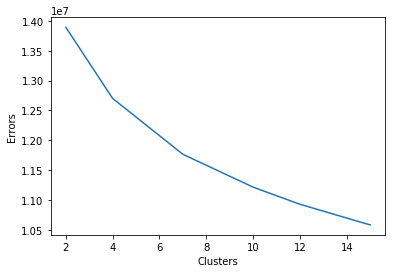

CPU times: user 3.35 s, sys: 886 ms, total: 4.23 s
Wall time: 7min 8s


In [20]:
%%time
# 'scaled_segments' contains the scaled data of the song segments
sc = StandardScaler()
scaled_segments = sc.fit_transform(song_segments)

# Build KMeans Clustering with various Cluster sizes and decide the Cluster size using the Elbow method
errors = []; clusters = [2, 4, 7, 10, 12, 15];
for i in clusters:
    print(f'Starting Cluster #{i}')
    model = KMeans(n_clusters=i, random_state=42, verbose=0, n_jobs=3)
    model.fit(scaled_segments)
    errors.append(model.inertia_)

plt.plot(clusters, errors)
plt.xlabel('Clusters')
plt.ylabel('Errors')
plt.show()

In [21]:
%%time
# Build the final Model based on the optimal cluster size obtained above and build the Clusters
model = KMeans(n_clusters=7, random_state=42, verbose=0, n_jobs=3)
model.fit(scaled_segments)

cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}

CPU times: user 459 ms, sys: 72.6 ms, total: 532 ms
Wall time: 1min 1s


In [22]:
for i in cluster_sets:
    print(f'Cluster# {i} Size ===> {len(cluster_sets[i])}')

Cluster# 0 Size ===> 83008
Cluster# 1 Size ===> 68226
Cluster# 2 Size ===> 60774
Cluster# 3 Size ===> 116995
Cluster# 4 Size ===> 72959
Cluster# 5 Size ===> 25243
Cluster# 6 Size ===> 74594


In [23]:
%%time
# 'cluster_segs' contains all the clustered segments per cluster (0-6)
cluster_segs = defaultdict(list)
clust_num = 0

for c in cluster_sets:
    for i in cluster_sets[c]:
        cluster_segs[clust_num].append(scaled_segments[i])
    clust_num += 1

CPU times: user 269 ms, sys: 9.83 ms, total: 279 ms
Wall time: 290 ms


In [0]:
def run_recomm(distances, indices, recomms=10):
    '''
    This Function generates the Recommendations for each Cluster.
    '''
    print(f'Mean Distance: {np.mean(distances)}, Median Distance: {np.median(distances)}\n')
    mean_dist = np.mean(distances)
    median_dist = np.median(distances)

    def show_recomm(arr):
        '''
        This Function displays the identified recommendations.
        '''
        ref_uri = song_seg_mapping[repr(list(song_segments.iloc[arr[0]].values))]
        if ref_uri.split('/')[-1] != sel_uri.split(':')[-1]:
            return False
        
        print(f'Recommendation# {count}:')
#         print(f'Indices: {arr}')
        
        ref_segment = song_segments.iloc[arr[0]].values
        start_time = song_segments.iloc[arr[0]]['start']
        end_time = start_time + song_segments.iloc[arr[0]]['duration']
        print(f'Reference Track: {ref_uri} {round(start_time, 2)}-{round(end_time, 2)}')
        
        for i in arr[1:]:
            try:
                start_time = song_segments.iloc[i]['start']
                end_time = start_time + song_segments.iloc[i]['duration']
                uri = song_seg_mapping[repr(list(song_segments.iloc[i].values))]
                
                # Following code removes similar song segments of the Referenced song
#                 if uri.split('/')[-1] != sel_uri.split(':')[-1]:
#                     continue
                
                # Following code calculates the References song segment vector from the similar segment vector and evaluates the audio property it's closest to.
                seg_distance = abs(ref_segment - song_segments.iloc[i].values)
                most_similar_property = song_segments.columns[np.argsort(seg_distance)[0]]
                                
                print(f'{uri} {round(start_time, 2)}-{round(end_time, 2)} (Most Similar Property: {most_similar_property})')
            except KeyError as err:
                print(f'Key Not Found for Index: {i}')
        print("\n")
        
        return True
    
    # 'count' keeps a track of the Max recommendations per Cluster
    count = 1
    ret = False
    for dist, indx in zip(distances, indices):
        
        if count > recomms:
            break
        
        flag = False
        temp = []
        for i in range(1, len(dist)):
            # IF the distance between the data-points is less the median distance for the Cluster then it is marked for recommendation
            if dist[i] <= median_dist:
                if not flag:
                    flag = True
                    temp.append(indx[0])
                temp.append(indx[i])
        if len(temp) > 0:
#             print(f'Recommendation# {count}:')
            ret = show_recomm(temp)
            if ret:
                count += 1

In [42]:
%%time
# Run the Recommendation engine for all the Clusters capping at 5 per cluster.
for i in cluster_segs:
    print(f'Cluster# {i+1}\n----------\n')
    
    nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', n_jobs=-1)
    nbrs = nn.fit(cluster_segs[i])
    distances, indices = nbrs.kneighbors(cluster_segs[i])
    print('5-NN evaludation complete.')
    
    run_recomm(distances, indices)

Cluster# 1
----------

5-NN evaludation complete.
Mean Distance: 2.1578354017210786, Median Distance: 2.573384153503792

Recommendation# 1:
Reference Track: https://open.spotify.com/track/0X0ClM8jVHU7N0ptHRqi7r 1.42-1.57
https://open.spotify.com/track/5W1Qt1tvO4OESyz7up2dkW 78.88-79.03 (Most Similar Property: duration)
https://open.spotify.com/track/1hr58cC3N5WwL7CF4yDTxh 67.26-67.41 (Most Similar Property: pitches_5)


Recommendation# 2:
Reference Track: https://open.spotify.com/track/0X0ClM8jVHU7N0ptHRqi7r 6.07-6.17
https://open.spotify.com/track/7v1epxqvIr4KUVLj8rN2cb 231.15-231.32 (Most Similar Property: loudness_max_time)


Recommendation# 3:
Reference Track: https://open.spotify.com/track/0X0ClM8jVHU7N0ptHRqi7r 8.71-9.07
https://open.spotify.com/track/0X0ClM8jVHU7N0ptHRqi7r 10.12-10.51 (Most Similar Property: pitches_0)


Recommendation# 4:
Reference Track: https://open.spotify.com/track/0X0ClM8jVHU7N0ptHRqi7r 9.32-9.47
https://open.spotify.com/track/0X0ClM8jVHU7N0ptHRqi7r 9.47-9